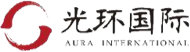

### 本案例的业务场景：

假如你们公司投放广告的渠道很多，每个渠道的客户性质也可能不同，比如在优酷视频投广告和今日头条投放广告，效果可能会有差异。现在需要对广告效果分析实现有针对性的广告效果测量和优化工作。


- 数据集

除了渠道唯一标识，共13个维度，889行
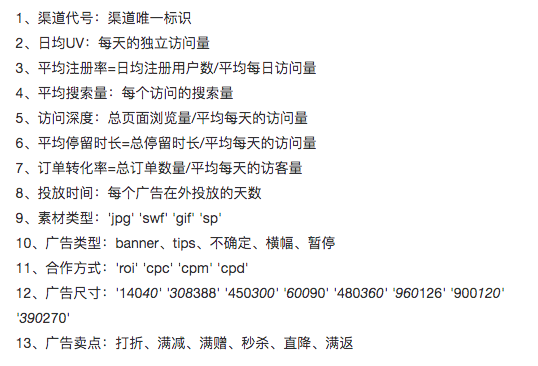

### 数据处理

In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score # 导入轮廓系数指标
from sklearn.cluster import KMeans # KMeans模块
%matplotlib inline
## 设置属性防止中文乱码：windows
# mpl.rcParams['font.sans-serif'] = [u'SimHei']
# mpl.rcParams['axes.unicode_minus'] = False
#设置属性防止中文乱码： mac
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['PingFang HK']

In [11]:
#加载样本数据：ad_performance.csv
data = pd.read_csv('./datasets/ad_performance.csv').drop(labels='Unnamed: 0',axis=1)
data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [12]:
#保留一份原始数据:data
op_data = data.copy()

### 缺失值处理

In [13]:
#检测哪些列出现缺失值
op_data.isnull().any()

渠道代号      False
日均UV      False
平均注册率     False
平均搜索量     False
访问深度      False
平均停留时间     True
订单转化率     False
投放总时间     False
素材类型      False
广告类型      False
合作方式      False
广告尺寸      False
广告卖点      False
dtype: bool

In [15]:
#查看存在缺失值的列出现的缺失值的个数
op_data['平均停留时间'].isnull().sum()

2

In [18]:
#使用众数mode对平均停留时间进行填充
mode = op_data['平均停留时间'].mode().mean()
op_data['平均停留时间'].fillna(value=mode,inplace=True)

In [19]:
#检测是否出现重复的行数据
op_data.duplicated().sum()

0

### 特征选择

- 基于相关性进行特征选择
    - 热力图：seaborn.heatmap(corr,cmap='Reds',annot=True)

<AxesSubplot:>

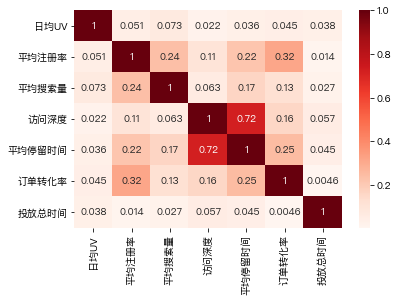

In [22]:
import seaborn as sns
corr = op_data.corr().abs()
sns.heatmap(corr,cmap='Reds',annot=True)

In [23]:
#发现平均停留时间和访问深度相关性比较高
op_data.drop(columns='平均停留时间',inplace=True)

In [25]:
#查看渠道代号有889个不同的元素，表示每一行的唯一表示，对于建模来讲无意义
op_data.drop(columns='渠道代号',inplace=True)

### 特征值化

- 类别型变量的特征值化
    - cols=["素材类型","广告类型","合作方式","广告尺寸","广告卖点"]


In [30]:
cols=["素材类型","广告类型","合作方式","广告尺寸","广告卖点"]
ret = pd.get_dummies(op_data[cols])
new_data = pd.concat((op_data,ret),axis=1).drop(columns=cols)

In [31]:
new_data.head()

,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型_gif,素材类型_jpg,素材类型_sp,素材类型_swf,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,3.69,0.0071,0.0214,2.3071,0.0258,20,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,178.70,0.0040,0.0324,2.0489,0.0030,19,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,91.77,0.0022,0.0530,1.8771,0.0026,4,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.09,0.0074,0.3382,4.2426,0.0153,10,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3.37,0.0028,0.1740,2.1934,0.0007,30,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


无量纲化的实现：注意只对没有进行one-hot编码的列进行无量纲化

In [32]:
from sklearn.preprocessing import MinMaxScaler
tool = MinMaxScaler()
ret = tool.fit_transform(new_data.iloc[:,0:6])

In [34]:
#将ret封装成DataFrame，然后替换原先的前6列
from pandas import DataFrame
cols = new_data.columns[:6]
mm_df = DataFrame(data=ret,columns=cols)
mm_df

,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间
0,0.000144,0.181586,0.020636,0.013340,0.119169,0.655172
1,0.007062,0.102302,0.031244,0.010705,0.013857,0.620690
2,0.003626,0.056266,0.051109,0.008952,0.012009,0.103448
3,0.000041,0.189258,0.326133,0.033095,0.070670,0.310345
4,0.000131,0.071611,0.167792,0.012180,0.003233,1.000000
...,...,...,...,...,...,...
884,0.070279,0.005115,0.002218,0.002641,0.000924,0.137931
885,0.077228,0.007673,0.002507,0.001738,0.000924,0.517241
886,0.012274,0.005115,0.002700,0.001578,0.000462,0.724138
887,0.054174,0.002558,0.001543,0.004020,0.000462,0.310345


In [36]:
#将无量纲化后的结果和原始表格中剩余的one-hot结果后的数据进行横向级联拼接
df = pd.concat((mm_df,new_data.iloc[:,6:]),axis=1)
#df中保存的就是经过了无量纲化之后的数据
df.head()

,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型_gif,素材类型_jpg,素材类型_sp,素材类型_swf,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,0.000144,0.181586,0.020636,0.013340,0.119169,0.655172,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.007062,0.102302,0.031244,0.010705,0.013857,0.620690,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.003626,0.056266,0.051109,0.008952,0.012009,0.103448,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.000041,0.189258,0.326133,0.033095,0.070670,0.310345,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.000131,0.071611,0.167792,0.012180,0.003233,1.000000,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### 建模

通过平均轮廓系数检验得到最佳KMeans聚类模型

In [39]:
#按照之前找寻最优模型超参数的套路实现
ks = [2,3,4,5,6,7] #簇的个数的取值
scores = [] #保存模型对应不同的簇的轮廓系数的值
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df)
    score = silhouette_score(df,model.labels_)
    scores.append(score)
ks = np.array(ks)
scores = np.array(scores)

best_index = np.argmax(scores)
best_k = ks[best_index]
best_k

4

In [40]:
#建模：
model = KMeans(n_clusters=best_k)
model.fit(df)
#获取每一个样本聚类的结果
labels = model.labels_

### 聚类结果特征分析与展示

通过上面模型，我们其实给每个观测（样本）打了个标签clusters，即他属于4类中的哪一类,将原始数据与聚类标签整合

In [41]:
data['cluster'] = labels
data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,cluster
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折,0
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减,0
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减,0
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减,0
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减,0


- 查看，每个类别下的样本数量和占比情况：

In [43]:
data['cluster'].value_counts().sort_index()

0    154
1    313
2    349
3     73
Name: cluster, dtype: int64

- 挖掘每个类别对应原始样本数据中最显著的特征（样本特征分为两类：数值型特征和非数值型特征）：
    - 数值型样本数据的特征
        - 计算其数值数据的均值即可
        - 例如【日均UV】特征在0类别的均值远远低于其他类别的均值说明0类别样本的UV出现问题
    - 非数值型样本数据的特征
        - 统计其出现频率最高的元素
    

In [49]:
all_value_data = [] #存储数值型特征的显著特征
all_str_data = [] #存储非数值型特征的显著特征

for k in range(4):#k的取值为0-3刚好可以作为每一个簇的标号
    #提取每一个簇对应的样本数据
    label_df = data.loc[data['cluster'] == k]
    #提取每一个簇中数值型特征的显著特征（每一个维度特征都需要进行显著特征的提取）
    value_s = label_df.iloc[:,1:7].describe().loc['mean']
    #将每一个簇对应数值型特征的显著特征存储到all_value_data
    all_value_data.append(value_s)
    
    #处理每一个簇中非数值型列的显著特征
    str_s = label_df.iloc[:,8:-1].describe().loc['top']
    all_str_data.append(str_s)

- 分析出的结论进行汇总展示

In [50]:
#每一个簇对应的样本数量计算出来
df_cluster_count = DataFrame(data=data['cluster'].value_counts().sort_index()).T
df_cluster_count

,0,1,2,3
cluster,154,313,349,73


In [51]:
#数值型特征的显著特征
value_cluster_df = DataFrame(data=all_value_data,index=[0,1,2,3]).T
value_cluster_df

,0,1,2,3
日均UV,613.835779,572.521054,300.205415,1401.524521
平均注册率,0.002649,0.001182,0.001099,0.001229
平均搜索量,0.020118,0.051364,0.015780,0.033232
访问深度,2.189583,2.144642,2.269508,1.727166
平均停留时间,247.765390,262.223344,237.134785,418.084932
订单转化率,0.003309,0.003868,0.001817,0.002475


In [52]:
#非数值型特征的显著特征
str_cluster_df = DataFrame(data=all_str_data,index=[0,1,2,3]).T
str_cluster_df

,0,1,2,3
素材类型,jpg,swf,jpg,swf
广告类型,banner,不确定,横幅,tips
合作方式,cpc,roi,cpc,cpm
广告尺寸,308*388,600*90,600*90,450*300
广告卖点,满减,打折,直降,打折


In [110]:
#将结论进行整体展示
pd.concat((df_cluster_count,value_cluster_df,str_cluster_df),axis=0)

,0,1,2,3
cluster,154,313,349,73
日均UV,613.836,572.521,300.205,1401.52
平均注册率,0.00264935,0.00118243,0.00109943,0.00122877
平均搜索量,0.0201175,0.0513642,0.0157797,0.0332315
访问深度,2.18958,2.14464,2.26951,1.72717
平均停留时间,247.765,262.223,237.135,418.085
订单转化率,0.00330909,0.00386837,0.00181662,0.00247534
素材类型,jpg,swf,jpg,swf
广告类型,banner,不确定,横幅,tips
合作方式,cpc,roi,cpc,cpm


- 结论：
    - 有73个样本的簇：
        - 这类广告媒体的显著特征是日均UV和注册率较高，其“引流”和“拉新”效果好，可以在广告媒体中定位为引流角色。
        - 符合“广而告之”的诉求，适合“拉新”使用。
    - 有249个样本的簇：
        - 这类广告的UV、平均注册率和订单转化率都为最低的其他方面除了访问深度指标最好外，无其他任何优势，则该渠道可以调整投放策略或者缩减投放成本或者直接砍掉。
    - 有313个样本的簇：
        - 这类广告媒体除了访问深度略差，在平均搜索量、日均UV、订单转化率等广告效果指标上表现良好，是一类综合效果较好的渠道。
        - 但是日均UV是短板，较低。无法给企业带来大量的流量以及新用户，这类广告的特质适合用户转化，尤其是有关订单的转化提升。
    - 有154个样本的簇：
        - 各个方面都表现良好正常